In [57]:
# ## 1. Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

In [58]:
# ## 2. Data Loading and Preprocessing
try:
    df = pd.read_csv("/content/data/uci-news-aggregator.csv")
    print("Dataset loaded successfully.")

    # 4개의 주요 카테고리만 필터링 (b, t, s, e)
    df = df[df['CATEGORY'].isin(['b', 't', 's', 'e'])]

    # 레이블 이름 변경
    category_map = {'b': 'Business', 't': 'Sci-Tech', 's': 'Sports', 'e': 'Entertainment'}
    df['CATEGORY'] = df['CATEGORY'].map(category_map)

    # 텍스트 클리닝
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # 숫자도 포함
        return text
    df['cleaned_title'] = df['TITLE'].apply(clean_text)

    print(f"\nFiltered dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'uci-news-aggregator.csv' not found. Please check the file path.")
    df = pd.DataFrame()

Dataset loaded successfully.

Filtered dataset shape: (376780, 9)


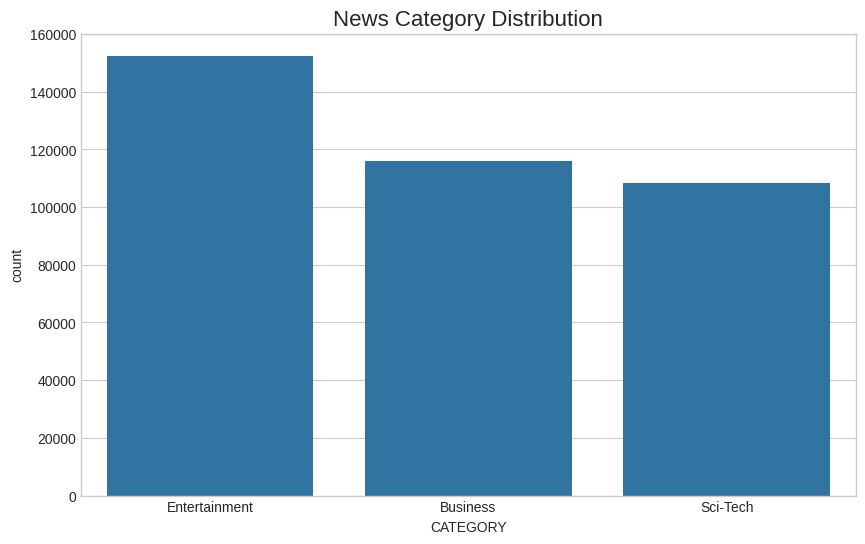

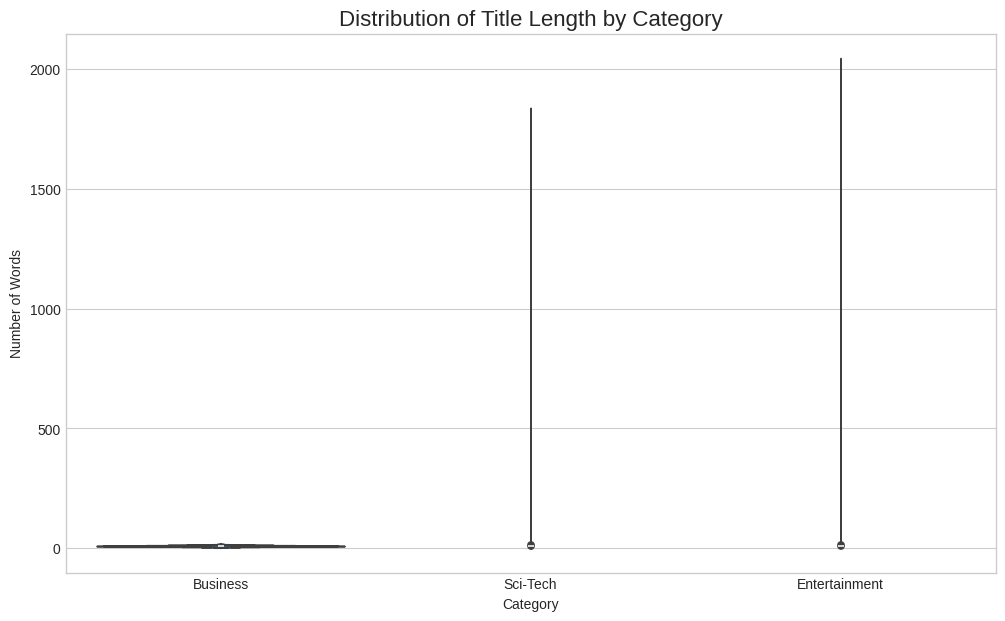

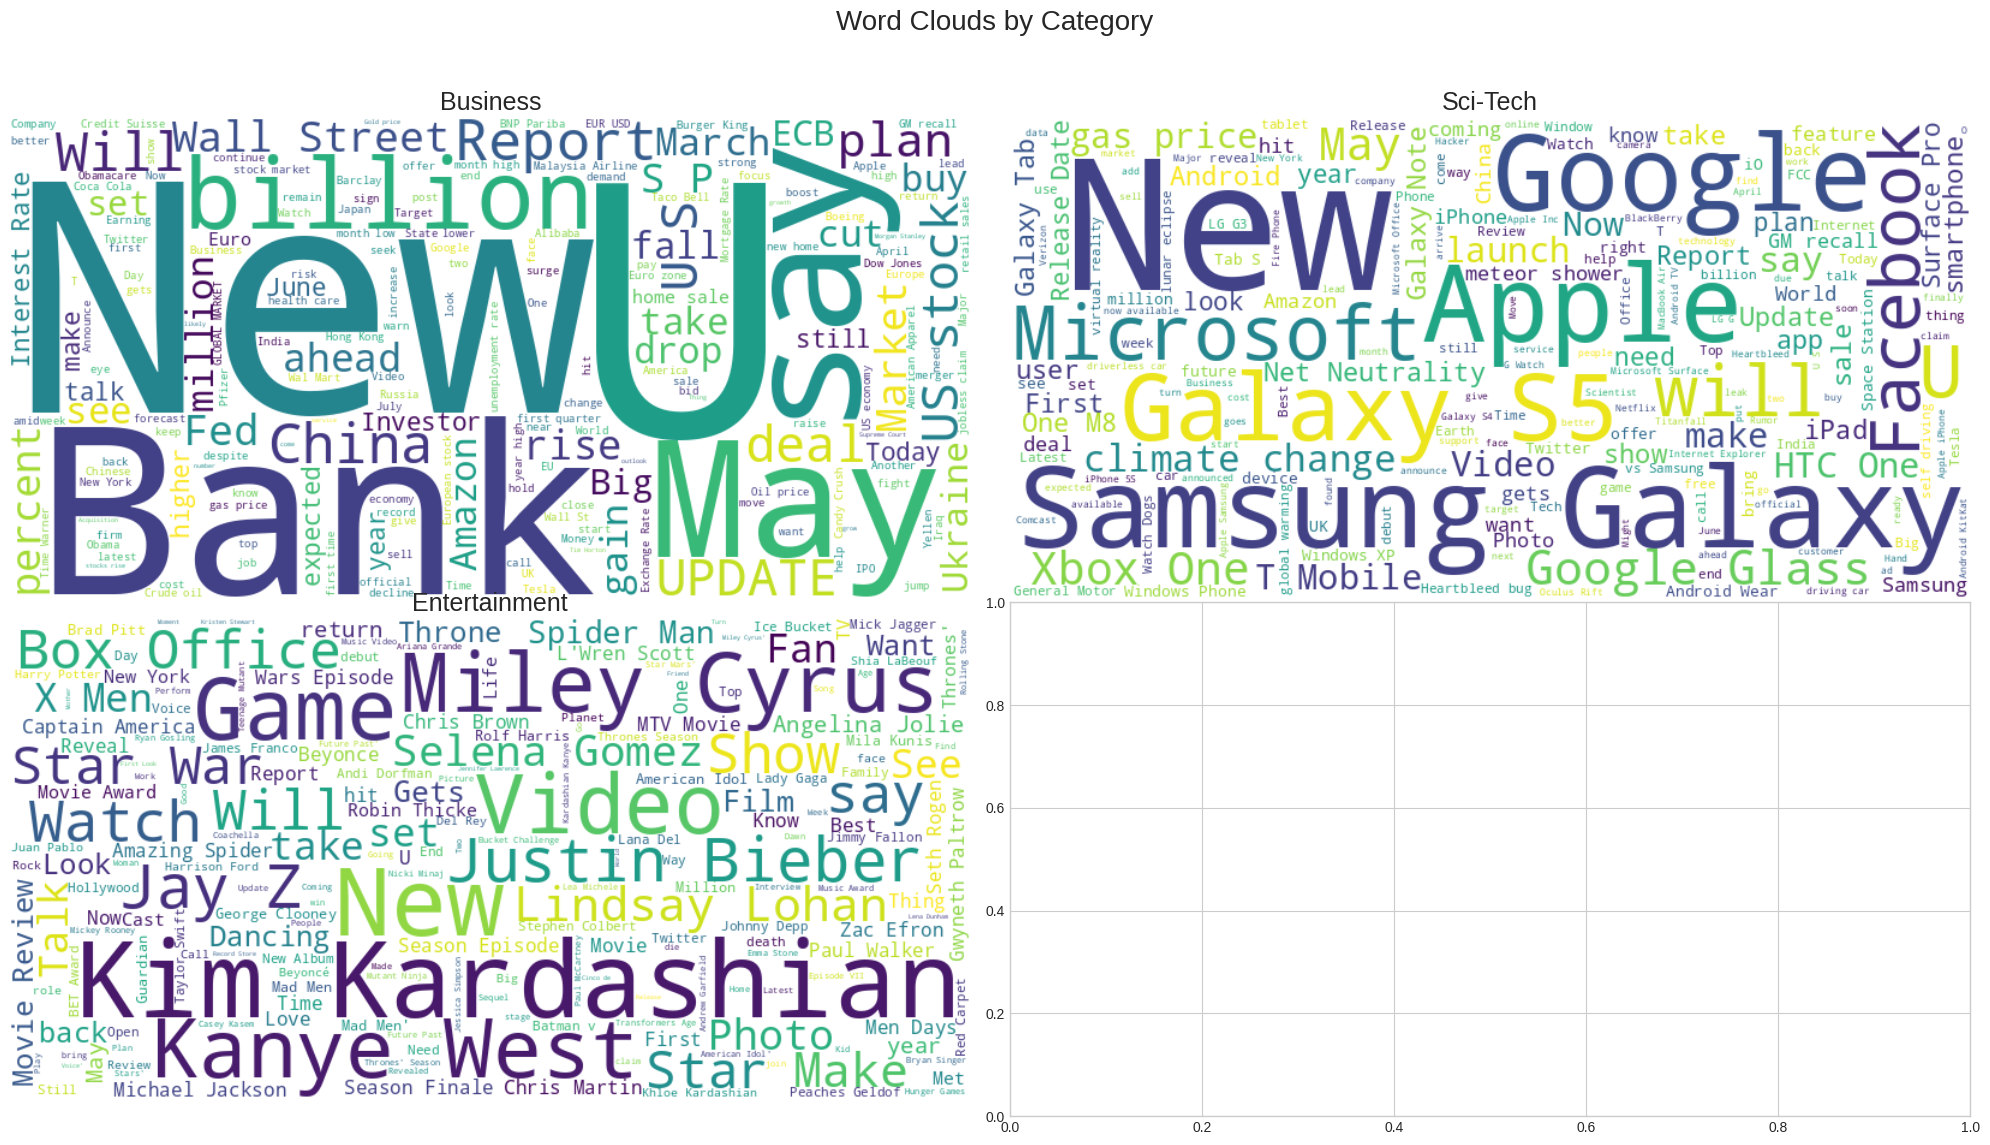

In [54]:
# ## 3. Exploratory Data Analysis (EDA)
if not df.empty:
    # 클래스 분포 확인
    plt.figure(figsize=(10, 6))
    sns.countplot(x='CATEGORY', data=df, order=df['CATEGORY'].value_counts().index)
    plt.title('News Category Distribution', fontsize=16)
    plt.show()

    # 제목 길이 분석
    df['title_length'] = df['TITLE'].apply(lambda x: len(str(x).split()))
    plt.figure(figsize=(12, 7))
    sns.violinplot(x='CATEGORY', y='title_length', data=df)
    plt.title('Distribution of Title Length by Category', fontsize=16)
    plt.xlabel('Category')
    plt.ylabel('Number of Words')
    plt.show()

    # 카테고리별 워드 클라우드
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Word Clouds by Category', fontsize=20)
    categories = df['CATEGORY'].unique()

    for i, category in enumerate(categories):
        text = " ".join(title for title in df[df['CATEGORY'] == category]['TITLE'])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        ax = axes[i//2, i%2]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(category, fontsize=18)
        ax.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [59]:
# ## Data Preparation for Models
if not df.empty:
    # 레이블 인코딩 및 원-핫 인코딩
    le = LabelEncoder()
    labels_encoded = le.fit_transform(df['CATEGORY'])
    labels = to_categorical(labels_encoded)
    class_names = list(le.classes_)

    # 훈련/테스트 데이터 분할
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        df['cleaned_title'], labels, test_size=0.2, random_state=42, stratify=labels
    )

    # ### 3.1. Character-level Tokenizer
    CHAR_VOCAB_SIZE = 80
    CHAR_MAX_LEN = 80

    tokenizer_char = Tokenizer(num_words=CHAR_VOCAB_SIZE, char_level=True, oov_token='<OOV>')
    tokenizer_char.fit_on_texts(X_train_text)
    X_train_char = pad_sequences(tokenizer_char.texts_to_sequences(X_train_text), maxlen=CHAR_MAX_LEN)
    X_test_char = pad_sequences(tokenizer_char.texts_to_sequences(X_test_text), maxlen=CHAR_MAX_LEN)

    # ### 3.2. Word-level Tokenizer
    WORD_VOCAB_SIZE = 11000
    WORD_MAX_LEN = 80

    tokenizer_word = Tokenizer(num_words=WORD_VOCAB_SIZE, oov_token='<OOV>')
    tokenizer_word.fit_on_texts(X_train_text)
    X_train_word = pad_sequences(tokenizer_word.texts_to_sequences(X_train_text), maxlen=WORD_MAX_LEN)
    X_test_word = pad_sequences(tokenizer_word.texts_to_sequences(X_test_text), maxlen=WORD_MAX_LEN)

    print(f"\nShape of char-level train data: {X_train_char.shape}")
    print(f"Shape of word-level train data: {X_train_word.shape}")


Shape of char-level train data: (301424, 80)
Shape of word-level train data: (301424, 80)


In [60]:
# ## 4. Model Building (Based on Notebook)
if not df.empty:
    # ### 4.1. Character-level CNN Model
    def create_char_model(emb_dim=128):
        inp = Input(shape=(CHAR_MAX_LEN,), name='char_input')
        emb = Embedding(CHAR_VOCAB_SIZE, emb_dim)(inp)
        drop1 = Dropout(rate=0.7)(emb)
        conv1 = Conv1D(256, 3, padding='valid', activation='relu', strides=1)(drop1)
        pool1 = GlobalMaxPooling1D()(conv1)
        dense1 = Dense(64, activation='relu')(pool1)
        drop2 = Dropout(rate=0.7)(dense1)
        return Model(inputs=inp, outputs=drop2, name='char_model')

    # ### 4.2. Word-level CNN Model
    def create_word_model(emb_dim=128):
        inp = Input(shape=(WORD_MAX_LEN,), name='word_input')
        emb = Embedding(WORD_VOCAB_SIZE, emb_dim)(inp)
        drop1 = Dropout(rate=0.7)(emb)
        conv1 = Conv1D(256, 3, padding='valid', activation='relu', strides=1)(drop1)
        pool1 = GlobalMaxPooling1D()(conv1)
        dense1 = Dense(64, activation='relu')(pool1)
        drop2 = Dropout(rate=0.7)(dense1)
        return Model(inputs=inp, outputs=drop2, name='word_model')

    # ### 4.3. Ensemble Model
    char_model = create_char_model()
    word_model = create_word_model()

    # 두 모델의 출력을 결합
    combined_input = concatenate([char_model.output, word_model.output])

    # 앙상블 분류기
    ensemble_dense1 = Dense(64, activation='relu')(combined_input)
    ensemble_drop = Dropout(0.8)(ensemble_dense1)
    ensemble_output = Dense(len(class_names), activation='softmax')(ensemble_drop)

    ensemble_model = Model(inputs=[char_model.input, word_model.input], outputs=ensemble_output)

    ensemble_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\n--- Ensemble Model Summary ---")
    ensemble_model.summary()


--- Ensemble Model Summary ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_input          │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 80, 128)   │     10,240 │ char_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 80, 128)   │  1,408,000 │ word_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 80, 128)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 80, 128)   │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 78, 256)   │     98,560 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 78, 256)   │     98,560 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │     16,448 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │     16,448 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 3)         │        195 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,656,707 (6.32 MB)

 Trainable params: 1,656,707 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# ## 5. Model Training
if not df.empty:
    print("\n--- Training Ensemble Model ---")
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = ensemble_model.fit(
        [X_train_char, X_train_word],
        y_train,
        epochs=20, # EarlyStopping이 최적의 epoch에서 중단
        batch_size=256,
        validation_data=([X_test_char, X_test_word], y_test),
        callbacks=[early_stopping]
    )


--- Training Ensemble Model ---
Epoch 1/20
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 48s 25ms/step - accuracy: 0.5477 - loss: 0.8353 - val_accuracy: 0.6942 - val_loss: 0.5170
Epoch 2/20
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6913 - loss: 0.5292 - val_accuracy: 0.6941 - val_loss: 0.4946
Epoch 3/20
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6930 - loss: 0.5051 - val_accuracy: 0.6939 - val_loss: 0.4914
Epoch 4/20
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.6947 - loss: 0.4935 - val_accuracy: 0.6950 - val_loss: 0.4903
Epoch 5/20
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.6947 - loss: 0.4871 - val_accuracy: 0.6950 - val_loss: 0.4894
Epoch 6/20
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6958 - loss: 0.4811 - val_accuracy: 0.6952 - val_loss: 0.4919
Epoch 7/20
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6981 - loss: 0.4789 - val_accuracy: 0.6931 - val_loss: 0.4928
Epoch 8/20
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 2


--- Detailed Analysis of Ensemble Model ---


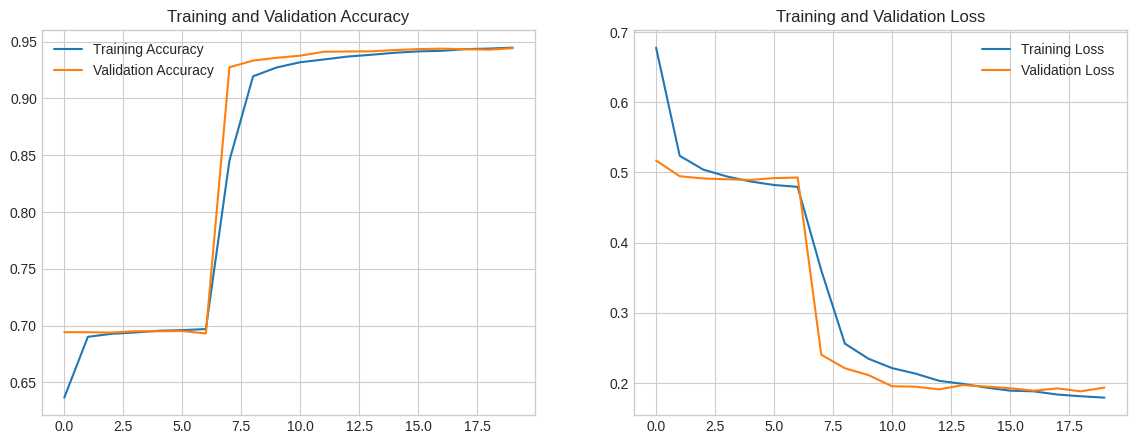

2355/2355 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9425 - loss: 0.1854

Ensemble Model Test Accuracy: 94.30%
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


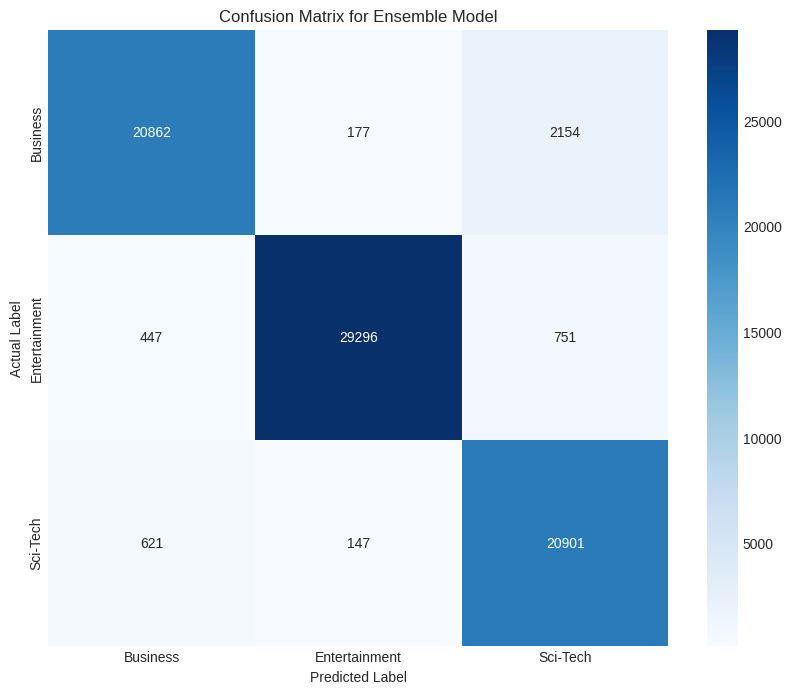


Classification Report for Ensemble Model
               precision    recall  f1-score   support

     Business       0.95      0.90      0.92     23193
Entertainment       0.99      0.96      0.97     30494
     Sci-Tech       0.88      0.96      0.92     21669

     accuracy                           0.94     75356
    macro avg       0.94      0.94      0.94     75356
 weighted avg       0.95      0.94      0.94     75356



In [62]:
# ## 6. Results Analysis
if not df.empty and 'history' in locals():
    print("\n--- Detailed Analysis of Ensemble Model ---")

    # 학습 곡선 시각화
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # 최종 평가
    loss, accuracy = ensemble_model.evaluate([X_test_char, X_test_word], y_test)
    print(f'\nEnsemble Model Test Accuracy: {accuracy*100:.2f}%')

    y_pred_probs = ensemble_model.predict([X_test_char, X_test_word])
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for Ensemble Model')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Classification Report
    print('\nClassification Report for Ensemble Model')
    print(classification_report(y_true, y_pred, target_names=class_names))